**Author:** Giuseppe Muschetta
**Python version:** 3.11

# K-Means Prototype Partitional Clustering
# Further dataset exploration

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
%matplotlib inline

In [3]:
# CONFIGURAZIONE DEI VARI PATH:
input_dataset_path = "./dataset/earthquakes_prepared.csv"
images_saving_path = "./images/clustering_exploration_kmeans/"
output_dataset_path = "./dataset/earthquakes_prepared_outliered_kmeans_labeled"

In [4]:
# STARTING SPARK SESSION

spark = (SparkSession
         .builder
         .master('local[*]')
         .appName("Project")
         .config("spark.driver.memory", "4g")
         .config("spark.executor.memory", "4g")
         .config("spark.driver.maxResultSize", "2g")
         # Usa il garbage collector G1
         .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC")
         .getOrCreate())

# sopprime i fastidiosissimi warning
spark.sparkContext.setLogLevel("ERROR")

spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/11 20:29:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Leggo il dataset pulito e preparato
df = spark.read.option("escape","\"").csv(input_dataset_path, header=True, inferSchema=True)

In [6]:
df.show()

+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+
|                time|          latitude|          longitude|             depth| mag|magType|  gap|                dmin| rms|             updated|               place| nst|magNst|
+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+
|1971-12-08 07:43:...|47.842833299999995|-119.62116670000002|             6.518| 1.6|     md|301.0|              0.4872|0.12|2016-07-25 01:51:...|          Washington| 7.0|   7.0|
|1972-11-15 10:11:...|        46.8286667|           -119.473|1.3880000000000001| 0.9|     md|194.0|             0.03549|0.12|2016-07-25 01:57:...|          Washington| 8.0|   8.0|
|1972-11-21 10:27:...|        34.0848333|-116.78233329999999|               6.0|2.83|     ml| 87.0| 

In [7]:
df.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- depth: double (nullable = true)
 |-- mag: double (nullable = true)
 |-- magType: string (nullable = true)
 |-- gap: double (nullable = true)
 |-- dmin: double (nullable = true)
 |-- rms: double (nullable = true)
 |-- updated: timestamp (nullable = true)
 |-- place: string (nullable = true)
 |-- nst: double (nullable = true)
 |-- magNst: double (nullable = true)


In [8]:
df.count()

2607588

## Clustering Columns

We will perform clustering using the following data columns:

- **latitude**: Represents the latitude where the seismic event was recorded. This angular measure indicates north-south position.

- **longitude**: Indicates the longitude of the seismic event, an angular measure defining the east-west position.

- **depth**: Depth of the earthquake origin below the surface, typically in kilometers.

- **mag**: Magnitude of the earthquake, indicating its relative size or energy.

- **nst**: Number of seismic stations used to record the earthquake.

- **magNst**: Number of stations used to calculate the earthquake's magnitude.

- **gap**: Azimuthal Gap, the largest angle between two stations from the epicenter, in degrees.

- **dmin**: Shortest distance from the epicenter to the nearest station.

- **rms**: Root Mean Square of time residuals of seismic waves at different stations.


In [9]:
# Scelgo le colonne per il clustering e preparo il dataframe sul quale applicare 
# i metodi del gomito (che usa l'SSE o Inertia) e della Silhouette per trovare 
# il valore più appropriato per l'iper-parametro k
columns_for_clustering = ["latitude", "longitude", "depth", "mag", "nst", "magNst", "gap", "dmin", "rms"]
vectorAssembler= VectorAssembler(inputCols=columns_for_clustering, outputCol="features")
df_clustering  = vectorAssembler.transform(df)

In [10]:
# Prina di eseguire il clustering devo standardizzare le variabili d'interesse:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(df_clustering)
df_clustering = scaler_model.transform(df_clustering)

In [11]:
df_clustering.show()

+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+--------------------+--------------------+
|                time|          latitude|          longitude|             depth| mag|magType|  gap|                dmin| rms|             updated|               place| nst|magNst|            features|      scaledFeatures|
+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+--------------------+--------------------+
|1971-12-08 07:43:...|47.842833299999995|-119.62116670000002|             6.518| 1.6|     md|301.0|              0.4872|0.12|2016-07-25 01:51:...|          Washington| 7.0|   7.0|[47.8428332999999...|[2.47475552165791...|
|1972-11-15 10:11:...|        46.8286667|           -119.473|1.3880000000000001| 0.9|     md|194.0|             

In [12]:
# METODO DEL GOMITO E DELLA SILHOUETTE:
min_k = 2
max_k = 50
evaluator = ClusteringEvaluator(predictionCol="kmeans_labels")
inertia = []
silhouette_values = []
for k_ in range(min_k, max_k + 1):
    kmeans_ = KMeans(k=k_, 
                     initMode="k-means||", 
                     featuresCol="scaledFeatures", 
                     seed=42,
                     predictionCol="kmeans_labels")
    
    model = kmeans_.fit(df_clustering)
    df_labeled = model.transform(df_clustering)

    # Calcolo dell'Inertia
    sse = model.summary.trainingCost
    inertia.append(sse)

    # Calcolo del punteggio Silhouette
    silhouette_score = evaluator.evaluate(df_labeled)
    silhouette_values.append(silhouette_score)

# print("Inertia: ", inertia)
# print("Silhouette Scores: ", silhouette_values)

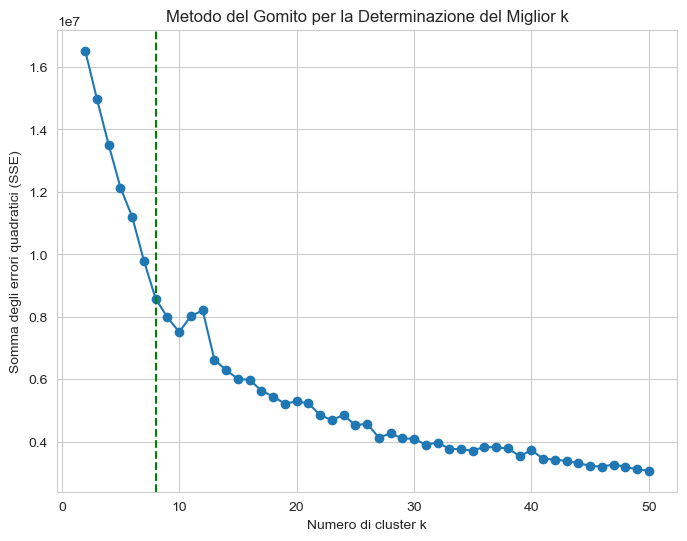

In [13]:
# VISUALIZZO LA CURVA SSE
plt.figure(figsize=(8, 6))
plt.plot(range(min_k, max_k + 1), inertia, marker='o')
plt.xlabel('Numero di cluster k')
plt.ylabel('Somma degli errori quadratici (SSE)')
plt.title('Metodo del Gomito per la Determinazione del Miglior k')

# Aggiungo una linea verticale per maggiore chiarezza visiva
plt.axvline(x=8, color='green', linestyle='--')
plt.savefig(images_saving_path + 'elbow_curve_exploration.png')
plt.show()

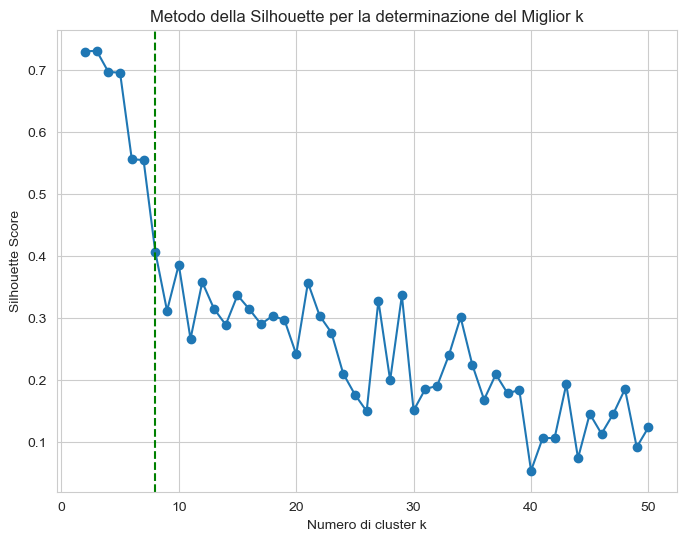

In [14]:
# VISUALIZZO LA CURVA SILHOUETTE
plt.figure(figsize=(8, 6))
plt.plot(range(min_k, max_k + 1), silhouette_values, marker='o')
plt.xlabel('Numero di cluster k')
plt.ylabel('Silhouette Score')
plt.title('Metodo della Silhouette per la determinazione del Miglior k')

# Aggiungo una linea verticale per maggiore chiarezza visiva
plt.axvline(x=8, color='green', linestyle='--')
plt.savefig(images_saving_path + 'silhouette_curve_exploration.png')
plt.show()

### STARTING DATA EXPLORATION WITH K-MEANS

In [15]:
# Applicazione del K-means con k=8
k = 8
kmeans = KMeans(k=k, 
                initMode="k-means||", 
                featuresCol="scaledFeatures",
                predictionCol="kmeans_labels",
                seed=42)

model = kmeans.fit(df_clustering)

# Trasforma i dati con il modello K-means per ottenere i cluster
# aggiunge a default la colonna 'prediction' contenente le etichette del clustering
df_clustering = model.transform(df_clustering)


In [16]:
df_clustering.show()

+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+--------------------+--------------------+-------------+
|                time|          latitude|          longitude|             depth| mag|magType|  gap|                dmin| rms|             updated|               place| nst|magNst|            features|      scaledFeatures|kmeans_labels|
+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+--------------------+--------------------+-------------+
|1971-12-08 07:43:...|47.842833299999995|-119.62116670000002|             6.518| 1.6|     md|301.0|              0.4872|0.12|2016-07-25 01:51:...|          Washington| 7.0|   7.0|[47.8428332999999...|[2.47475552165791...|            5|
|1972-11-15 10:11:...|        46.8286667|           -119

In [17]:
# Applicazione della PCA a due componenti per il plotting a 2 dimensioni
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(df_clustering)
df_clustering = pca_model.transform(df_clustering)

In [18]:
df_clustering.show()

+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+--------------------+--------------------+-------------+--------------------+
|                time|          latitude|          longitude|             depth| mag|magType|  gap|                dmin| rms|             updated|               place| nst|magNst|            features|      scaledFeatures|kmeans_labels|         pcaFeatures|
+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+--------------------+--------------------+-------------+--------------------+
|1971-12-08 07:43:...|47.842833299999995|-119.62116670000002|             6.518| 1.6|     md|301.0|              0.4872|0.12|2016-07-25 01:51:...|          Washington| 7.0|   7.0|[47.8428332999999...|[2.47475552165791...|        

In [19]:
# Estrai le componenti PCA per il plotting
pandas_df = df_clustering.select("pcaFeatures", "kmeans_labels").toPandas()
pandas_df['pca_x'] = pandas_df['pcaFeatures'].apply(lambda x: x[0])
pandas_df['pca_y'] = pandas_df['pcaFeatures'].apply(lambda x: x[1])

pandas_df.drop(columns=['pcaFeatures'], inplace=True)

In [20]:
pandas_df.head(20)

,kmeans_labels,pca_x,pca_y
0,5,-0.834317,2.090285
1,5,-1.020115,0.847971
2,0,0.438267,0.251659
3,5,0.574445,2.134041
4,5,0.542470,0.964153
5,0,-0.414011,-0.224604
6,5,0.120287,0.955643
7,0,-0.928634,0.141059
8,5,-0.523395,0.772406
9,0,-0.736161,-0.177813


/Users/peppe212/anaconda3/envs/distributed_data_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/peppe212/anaconda3/envs/distributed_data_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/peppe212/anaconda3/envs/distributed_data_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/peppe212/anaconda3/envs/distributed_data_analysis/lib/python3.11/site-packages/seaborn/_oldcore.

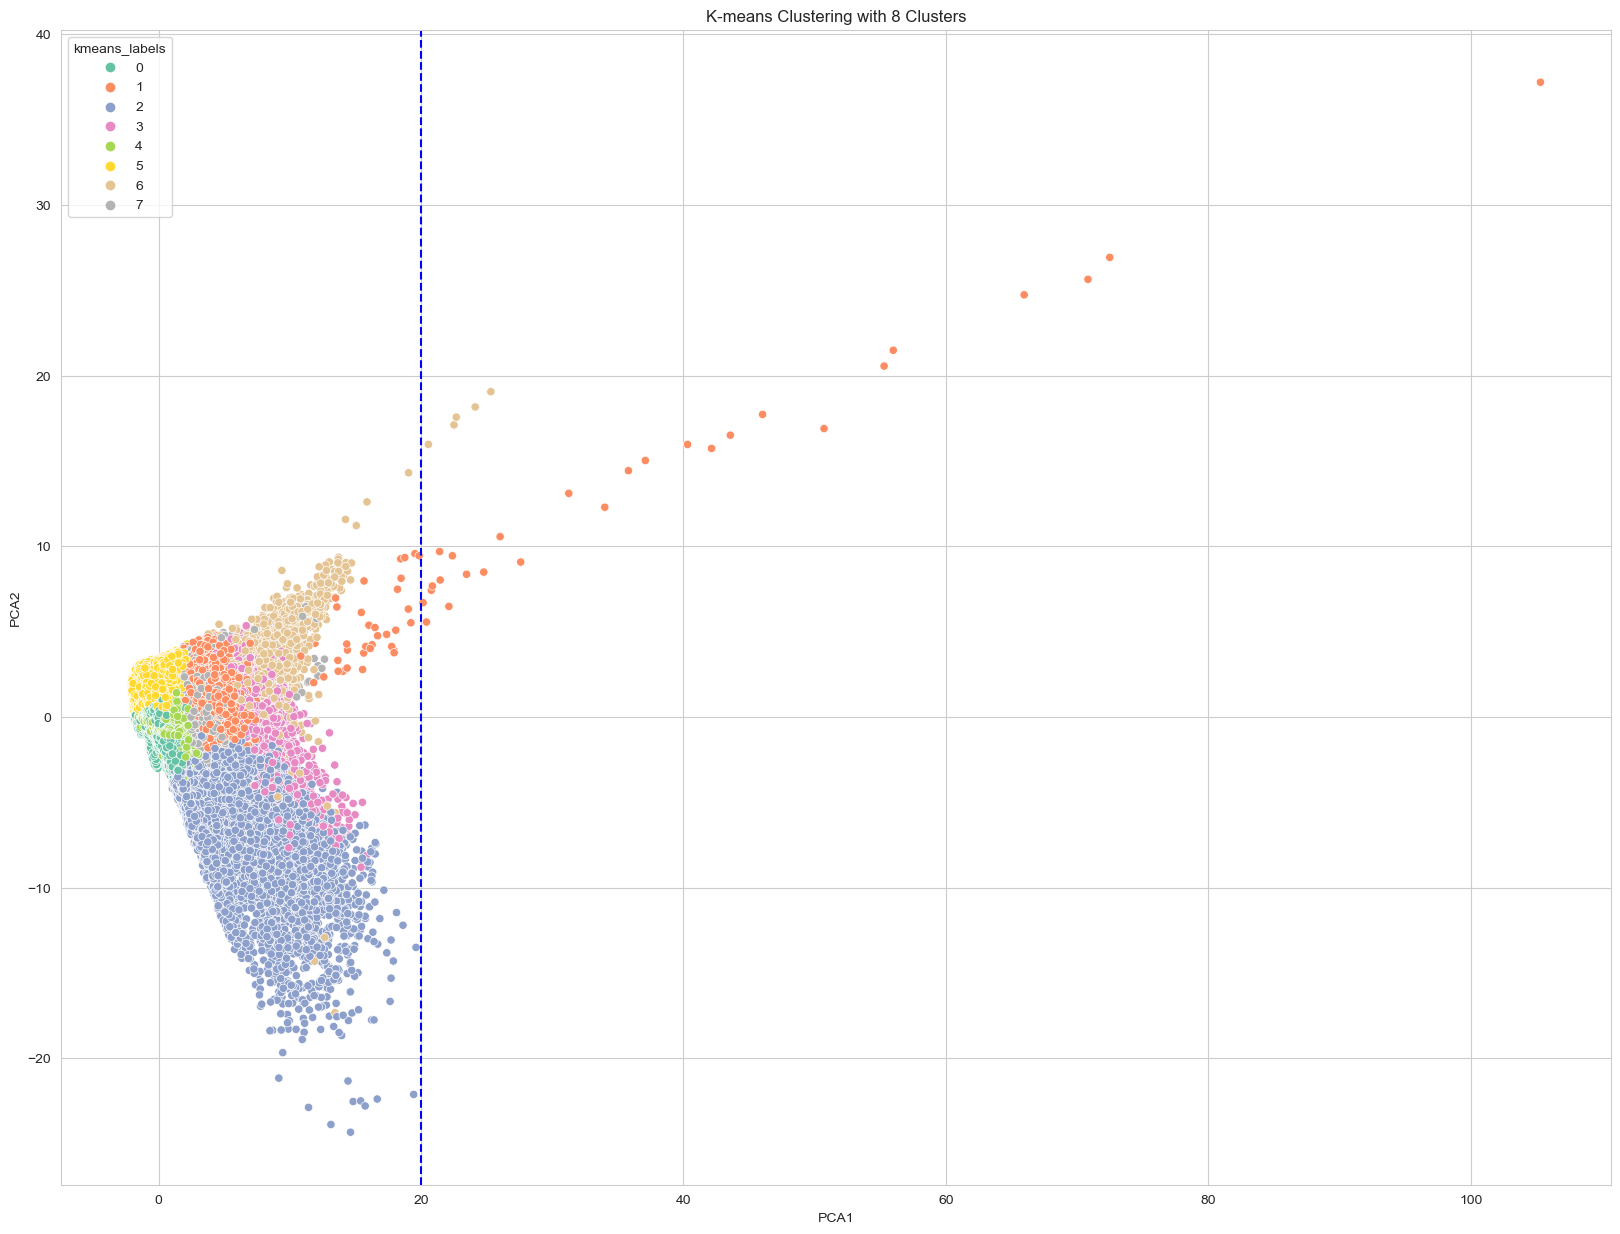

In [21]:
# Plot dei clusters usando seaborn
chosen_palette = sns.color_palette("Set2", k) # si riferisce al k usato dal k-means
plt.figure(figsize=(20, 15))
sns.scatterplot(data=pandas_df, x="pca_x", y="pca_y", hue=pandas_df['kmeans_labels'], palette=chosen_palette)
plt.axvline(x=20, color='blue', linestyle='--')
plt.title('K-means Clustering with 8 Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.savefig(images_saving_path + "PCA_kmeans_clusters")
plt.show()

In [22]:
# Questa immagine mi consente di visualizzare concretamente quei valori giganteschi e
# palesemente fuori scala che vedevo nelle stats iniziali in fase di datas understanding
# e che volevo eliminare, adesso ho l'opportunità di farlo, filtro il dataframe in modo 
# da eliminare tutte le righe la cui componente principale è strettamente maggiore di 20

# A QUESTO PUNTO ELIMINIAMO QUESTI OUTLIERS GIA' CHE CI SIAMO:
# 1 - per prima cosa estraggo dalla colonna pcaFeatures entrambe le componenti e le mettiamo ciascuna in una colonna diversa
# 2 - filtriamo il dataframe affinché restino solo le righe per cui la componente 1 è minore o uguale a 20

# ESEGUO IL PRIMO PUNTO:
from pyspark.sql.functions import udf, lit
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import VectorUDT

# Definisco una UDF per estrarre elementi da un vettore
@udf(DoubleType())
def extract_vector_element(vector, position):
    return float(vector[position])

# Aggiungi due nuove colonne per le componenti PCA
df_clustering = df_clustering.withColumn("pca_1", extract_vector_element("pcaFeatures", lit(0))) \
    .withColumn("pca_2", extract_vector_element("pcaFeatures", lit(1)))


In [23]:
df_clustering.show()

+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+
|                time|          latitude|          longitude|             depth| mag|magType|  gap|                dmin| rms|             updated|               place| nst|magNst|            features|      scaledFeatures|kmeans_labels|         pcaFeatures|               pca_1|               pca_2|
+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+
|1971-12-08 07:43:...|47.842833299999995|-119.62116670000002|             6.518| 1.6|     md|301.0|    

In [24]:
df_clustering.count()

2607588

In [25]:
# FILTRO IL DATAFRAME:
from pyspark.sql.functions import col

# Mantiene solo le righe per cui pca_1 è minore o uguale a 20
df_filtered = df_clustering.filter(col("pca_1") <= 20)

In [26]:
df_filtered.count()
# praticamente erano solo 32 gli outliers piu' evidenti

2607556

/Users/peppe212/anaconda3/envs/distributed_data_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/peppe212/anaconda3/envs/distributed_data_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/peppe212/anaconda3/envs/distributed_data_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/peppe212/anaconda3/envs/distributed_data_analysis/lib/python3.11/site-packages/seaborn/_oldcore.

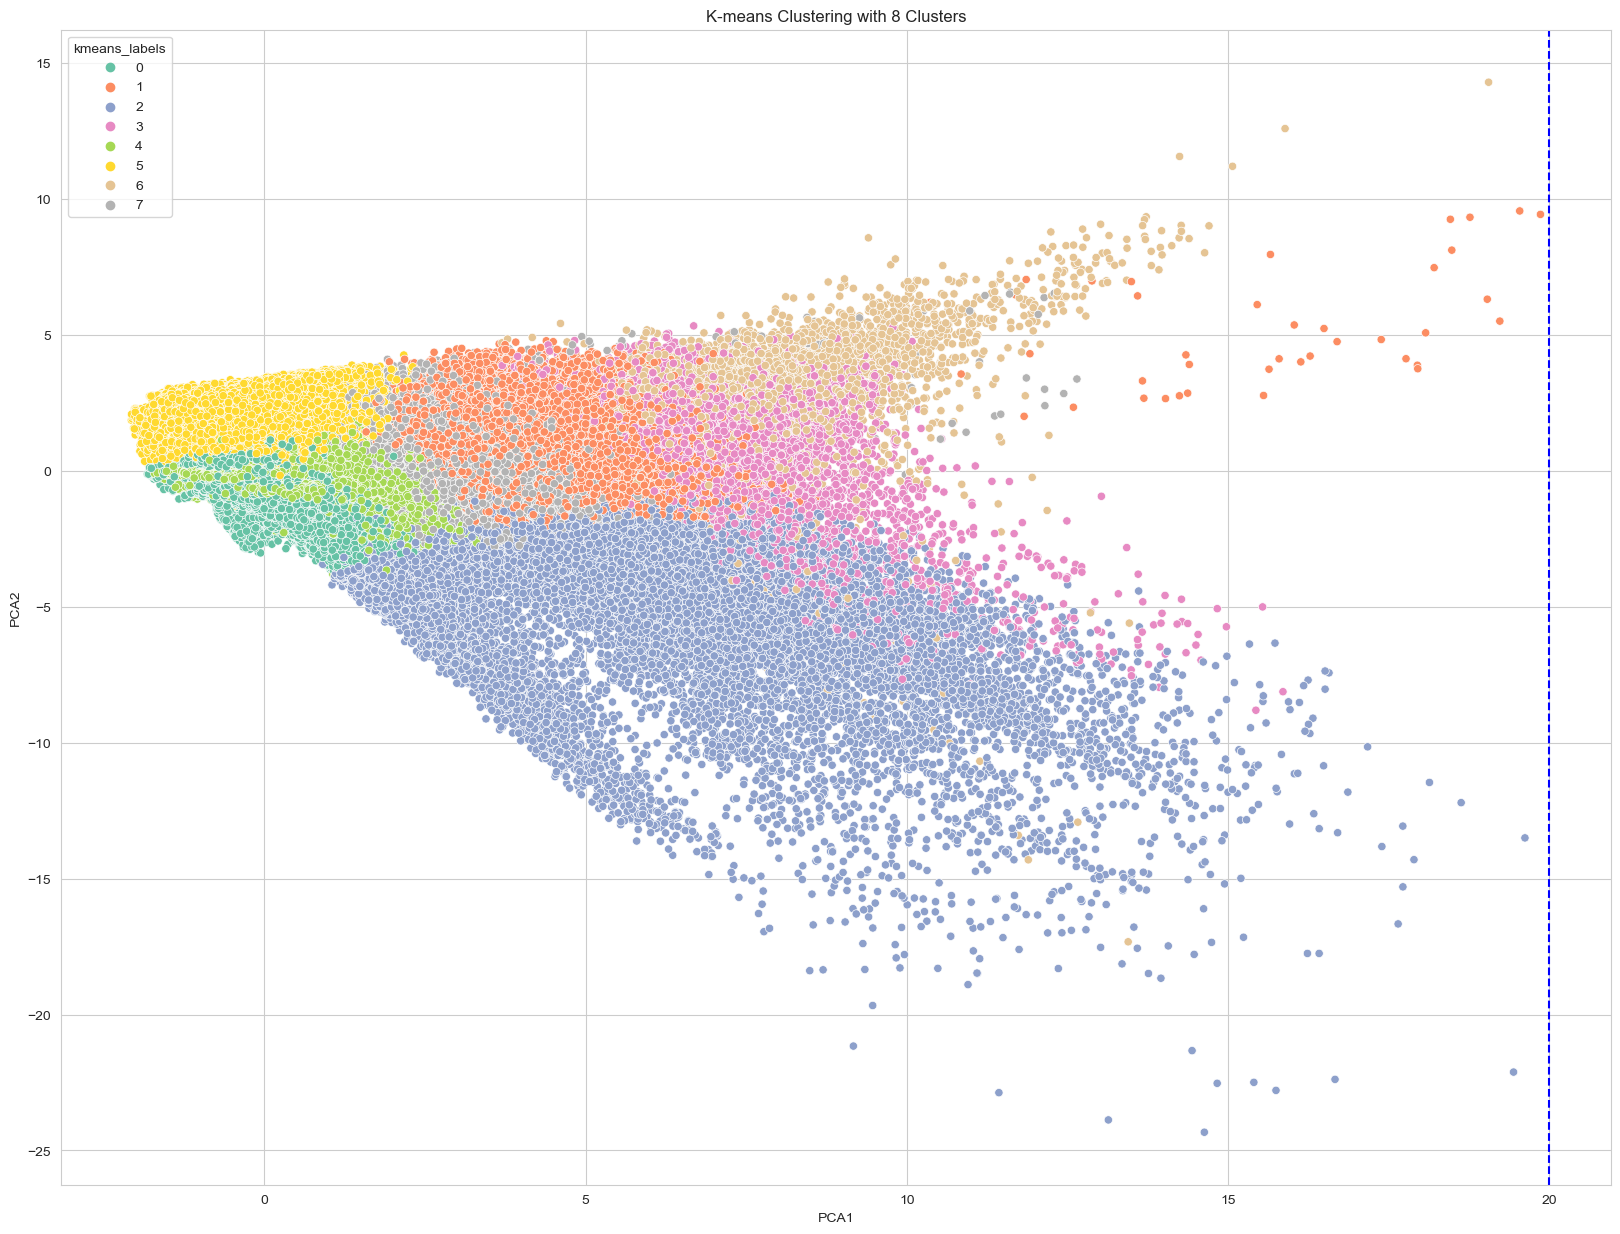

In [27]:
# adesso controlliamo di aver eliminato quei pochissimi punti:
pandas_df_no_out = df_filtered.select("pca_1", "pca_2", "kmeans_labels").toPandas()

# plottiamo il tutto
chosen_palette = sns.color_palette("Set2", k) # si riferisce al k usato dal k-means
plt.figure(figsize=(20, 15))
sns.scatterplot(data=pandas_df_no_out, x="pca_1", y="pca_2", hue=pandas_df_no_out['kmeans_labels'], palette=chosen_palette)
plt.axvline(x=20, color='blue', linestyle='--')
plt.title('K-means Clustering with 8 Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.savefig(images_saving_path + "PCA_kmeans_clusters_no_outliers")
plt.show()

### CLUSTERS STATS

In [28]:
from pyspark.sql.functions import col, mean, stddev, min, max, count

# Mi serve per calcolare le percentuali
total_points = df_filtered.count()

original_columns = ["latitude", "longitude", "depth", "mag", "nst", "magNst", "gap", "dmin", "rms"]
n_clusters = k

# Calcolo le statistiche descrittive per il cluster
for i in range(n_clusters):
    print(f"Statistiche per il cluster {i}:")

    # Creo un DataFrame che contiene solo i punti per il cluster corrente
    df_cluster = df_filtered.filter(col("kmeans_labels") == i)

    # Calcolo il numero di punti nel cluster corrente
    cluster_points = df_cluster.count()
    # Calcolo la percentuale di punti nel cluster corrente
    percentage = (cluster_points / total_points) * 100

    cluster_stats = df_cluster.select(
        *[mean(col(c)).alias(f'mean_{c}') for c in original_columns],
        *[stddev(col(c)).alias(f'stddev_{c}') for c in original_columns],
        *[min(col(c)).alias(f'min_{c}') for c in original_columns],
        *[max(col(c)).alias(f'max_{c}') for c in original_columns]
        # Raccolgo i risultati delle aggregazioni e prendo la prima riga
    ).collect()[0]  

    print(f"  Punti nel cluster: {cluster_points}")
    print(f"  Percentuale del totale: {percentage:.2f}%")
    
    for col_name in original_columns:
        print(f"  {col_name} - Media: {cluster_stats[f'mean_{col_name}']:.2f}, "
              f"Deviazione Standard: {cluster_stats[f'stddev_{col_name}']:.2f}, "
              f"Minimo: {cluster_stats[f'min_{col_name}']}, "
              f"Massimo: {cluster_stats[f'max_{col_name}']}")
    
    # lascio una ruga vuota per maggiore leggibilità
    print("\n") 


Statistiche per il cluster 0:


  Punti nel cluster: 1228039
  Percentuale del totale: 47.10%
  latitude - Media: 36.94, Deviazione Standard: 3.94, Minimo: -0.2422, Massimo: 65.1416
  longitude - Media: -118.00, Deviazione Standard: 13.58, Minimo: -179.67, Massimo: 179.6146667
  depth - Media: 6.08, Deviazione Standard: 5.12, Minimo: 0.001, Massimo: 165.0
  mag - Media: 1.31, Deviazione Standard: 0.65, Minimo: 0.01, Massimo: 6.3
  nst - Media: 15.60, Deviazione Standard: 13.29, Minimo: -3.295289784218477, Massimo: 155.0
  magNst - Media: 12.61, Deviazione Standard: 13.47, Minimo: 0.0, Massimo: 124.0
  gap - Media: 90.95, Deviazione Standard: 32.07, Minimo: 0.0, Massimo: 197.0
  dmin - Media: 0.09, Deviazione Standard: 0.10, Minimo: 0.0, Massimo: 7.537999999999999
  rms - Media: 0.11, Deviazione Standard: 0.08, Minimo: -1.0, Massimo: 1.0


Statistiche per il cluster 1:


  Punti nel cluster: 199238
  Percentuale del totale: 7.64%
  latitude - Media: -11.91, Deviazione Standard: 17.46, Minimo: -84.42200000000001, Massimo: 40.1356667
  longitude - Media: 40.43, Deviazione Standard: 118.08, Minimo: -179.997, Massimo: 179.99900000000002
  depth - Media: 57.69, Deviazione Standard: 57.12, Minimo: 0.01, Massimo: 305.9
  mag - Media: 4.52, Deviazione Standard: 0.54, Minimo: 0.16, Massimo: 8.3
  nst - Media: 39.21, Deviazione Standard: 19.92, Minimo: 0.0, Massimo: 212.0
  magNst - Media: 13.18, Deviazione Standard: 14.18, Minimo: 0.0, Massimo: 109.0
  gap - Media: 121.43, Deviazione Standard: 37.85, Minimo: 8.0, Massimo: 352.6
  dmin - Media: 0.83, Deviazione Standard: 1.46, Minimo: 0.004425999999999999, Massimo: 10.995999999999999
  rms - Media: 0.98, Deviazione Standard: 0.36, Minimo: 0.0, Massimo: 19.566


Statistiche per il cluster 2:


  Punti nel cluster: 38944
  Percentuale del totale: 1.49%
  latitude - Media: 26.09, Deviazione Standard: 22.28, Minimo: -77.08, Massimo: 86.816
  longitude - Media: -25.76, Deviazione Standard: 120.89, Minimo: -179.9963, Massimo: 179.9946
  depth - Media: 39.88, Deviazione Standard: 69.79, Minimo: 0.001, Massimo: 644.3
  mag - Media: 4.21, Deviazione Standard: 1.32, Minimo: 1.29, Massimo: 9.1
  nst - Media: 131.69, Deviazione Standard: 117.77, Minimo: 0.0, Massimo: 934.0
  magNst - Media: 112.52, Deviazione Standard: 75.25, Minimo: 0.0, Massimo: 854.0
  gap - Media: 68.64, Deviazione Standard: 45.94, Minimo: 6.5, Massimo: 334.0
  dmin - Media: 0.65, Deviazione Standard: 1.35, Minimo: 0.0, Massimo: 15.970999999999998
  rms - Media: 0.63, Deviazione Standard: 0.39, Minimo: 0.02, Massimo: 4.41


Statistiche per il cluster 3:


  Punti nel cluster: 25368
  Percentuale del totale: 0.97%
  latitude - Media: -10.40, Deviazione Standard: 20.30, Minimo: -59.483000000000004, Massimo: 55.715
  longitude - Media: -41.21, Deviazione Standard: 160.70, Minimo: -179.99900000000002, Massimo: 179.9993
  depth - Media: 498.41, Deviazione Standard: 99.65, Minimo: 242.41, Massimo: 735.8
  mag - Media: 4.44, Deviazione Standard: 0.48, Minimo: 2.1, Massimo: 8.3
  nst - Media: 56.31, Deviazione Standard: 41.37, Minimo: 5.0, Massimo: 646.0
  magNst - Media: 21.51, Deviazione Standard: 28.42, Minimo: 1.0, Massimo: 307.0
  gap - Media: 118.63, Deviazione Standard: 37.05, Minimo: 9.0, Massimo: 332.0
  dmin - Media: 1.41, Deviazione Standard: 2.17, Minimo: 0.066, Massimo: 14.245999999999999
  rms - Media: 0.86, Deviazione Standard: 0.24, Minimo: 0.07, Massimo: 2.03


Statistiche per il cluster 4:


  Punti nel cluster: 469400
  Percentuale del totale: 18.00%
  latitude - Media: 60.24, Deviazione Standard: 4.95, Minimo: 19.5376, Massimo: 85.154
  longitude - Media: -151.20, Deviazione Standard: 13.37, Minimo: -179.9983, Massimo: 27.271
  depth - Media: 35.33, Deviazione Standard: 38.01, Minimo: 0.001, Massimo: 300.0
  mag - Media: 1.68, Deviazione Standard: 0.76, Minimo: 0.01, Massimo: 5.9
  nst - Media: 24.17, Deviazione Standard: 10.05, Minimo: 0.0, Massimo: 164.0
  magNst - Media: 11.82, Deviazione Standard: 8.59, Minimo: 0.0, Massimo: 104.0
  gap - Media: 124.57, Deviazione Standard: 17.59, Minimo: 8.0, Massimo: 339.0
  dmin - Media: 0.31, Deviazione Standard: 0.21, Minimo: 0.0, Massimo: 8.025
  rms - Media: 0.55, Deviazione Standard: 0.22, Minimo: 0.0, Massimo: 4.34


Statistiche per il cluster 5:


  Punti nel cluster: 472058
  Percentuale del totale: 18.10%
  latitude - Media: 36.98, Deviazione Standard: 5.89, Minimo: -34.105, Massimo: 71.301
  longitude - Media: -117.61, Deviazione Standard: 15.85, Minimo: -179.9955, Massimo: 179.998
  depth - Media: 8.51, Deviazione Standard: 11.25, Minimo: 0.001, Massimo: 257.0
  mag - Media: 1.30, Deviazione Standard: 0.79, Minimo: 0.01, Massimo: 6.57
  nst - Media: 7.71, Deviazione Standard: 6.54, Minimo: -2.8944613964636705, Massimo: 126.0
  magNst - Media: 6.57, Deviazione Standard: 8.28, Minimo: 0.0, Massimo: 134.0
  gap - Media: 217.02, Deviazione Standard: 49.89, Minimo: 145.4, Massimo: 360.0
  dmin - Media: 0.18, Deviazione Standard: 0.23, Minimo: 0.0, Massimo: 5.654
  rms - Media: 0.12, Deviazione Standard: 0.13, Minimo: 0.0, Massimo: 2.285


Statistiche per il cluster 6:


  Punti nel cluster: 4612
  Percentuale del totale: 0.18%
  latitude - Media: -21.29, Deviazione Standard: 31.86, Minimo: -73.462, Massimo: 86.1559
  longitude - Media: 3.68, Deviazione Standard: 101.87, Minimo: -179.9479, Massimo: 179.9756
  depth - Media: 36.49, Deviazione Standard: 96.11, Minimo: 1.22, Massimo: 636.59
  mag - Media: 4.62, Deviazione Standard: 0.39, Minimo: 1.83, Massimo: 7.1
  nst - Media: 42.97, Deviazione Standard: 8.59, Minimo: 3.0, Massimo: 90.56834416052435
  magNst - Media: 31.05, Deviazione Standard: 43.38, Minimo: 2.0, Massimo: 657.0
  gap - Media: 116.95, Deviazione Standard: 52.79, Minimo: 16.0, Massimo: 343.0
  dmin - Media: 20.91, Deviazione Standard: 8.96, Minimo: 10.735, Massimo: 102.9
  rms - Media: 0.75, Deviazione Standard: 0.27, Minimo: 0.03, Massimo: 2.0


Statistiche per il cluster 7:


  Punti nel cluster: 169897
  Percentuale del totale: 6.52%
  latitude - Media: 37.70, Deviazione Standard: 12.16, Minimo: 6.47, Massimo: 87.221
  longitude - Media: 75.71, Deviazione Standard: 69.46, Minimo: -179.924, Massimo: 179.9999
  depth - Media: 33.48, Deviazione Standard: 41.57, Minimo: 0.01, Massimo: 324.7
  mag - Media: 3.91, Deviazione Standard: 0.85, Minimo: 0.17, Massimo: 8.3
  nst - Media: 41.46, Deviazione Standard: 18.82, Minimo: 0.0, Massimo: 223.0
  magNst - Media: 11.56, Deviazione Standard: 13.39, Minimo: 0.0, Massimo: 100.0
  gap - Media: 125.10, Deviazione Standard: 30.05, Minimo: 9.0, Massimo: 359.0
  dmin - Media: 0.48, Deviazione Standard: 0.85, Minimo: 0.001, Massimo: 11.196
  rms - Media: 0.94, Deviazione Standard: 0.37, Minimo: -1.0, Massimo: 12.9


													Mean for each cluster


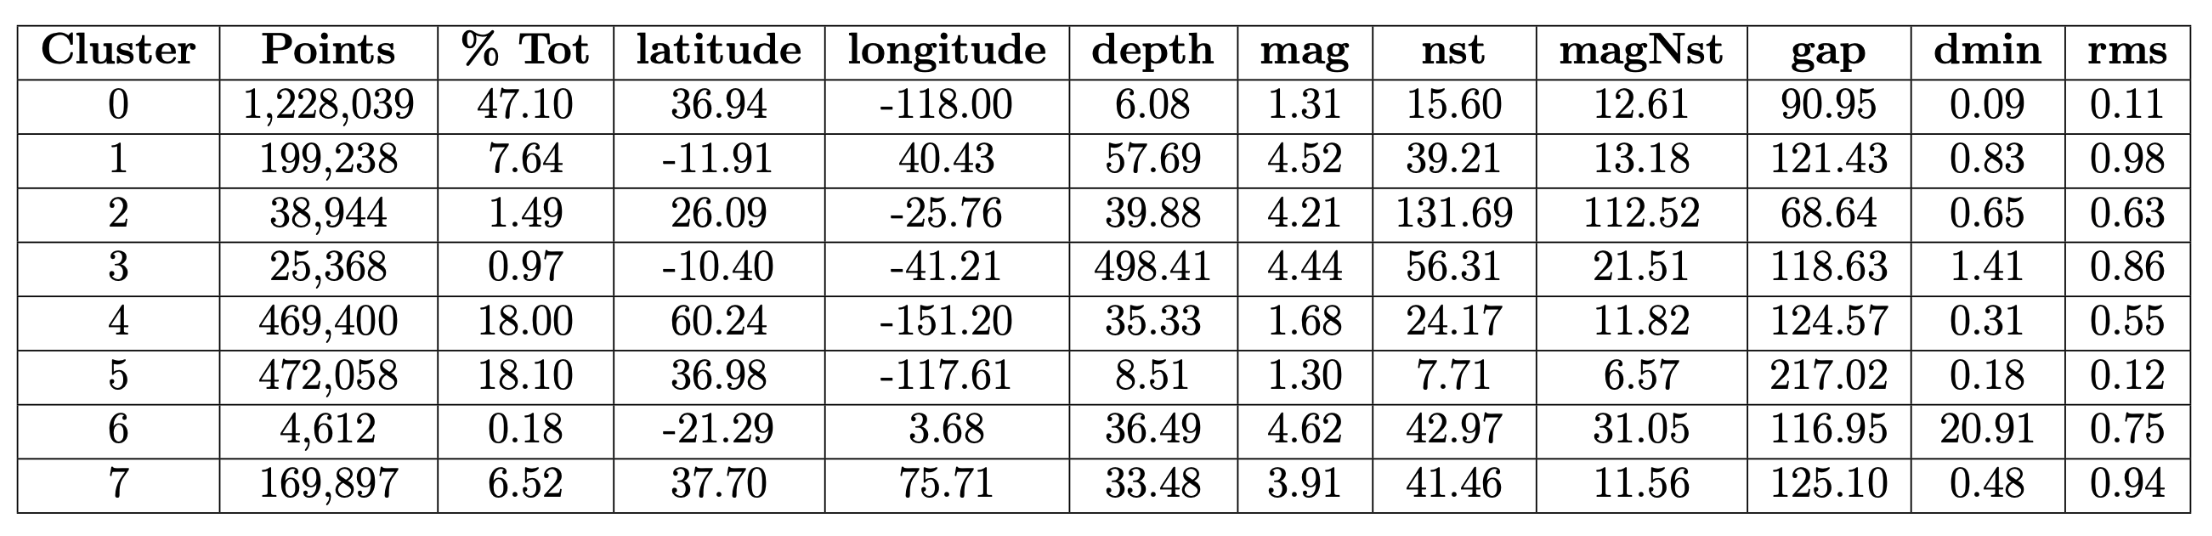

													Stddev for each cluster


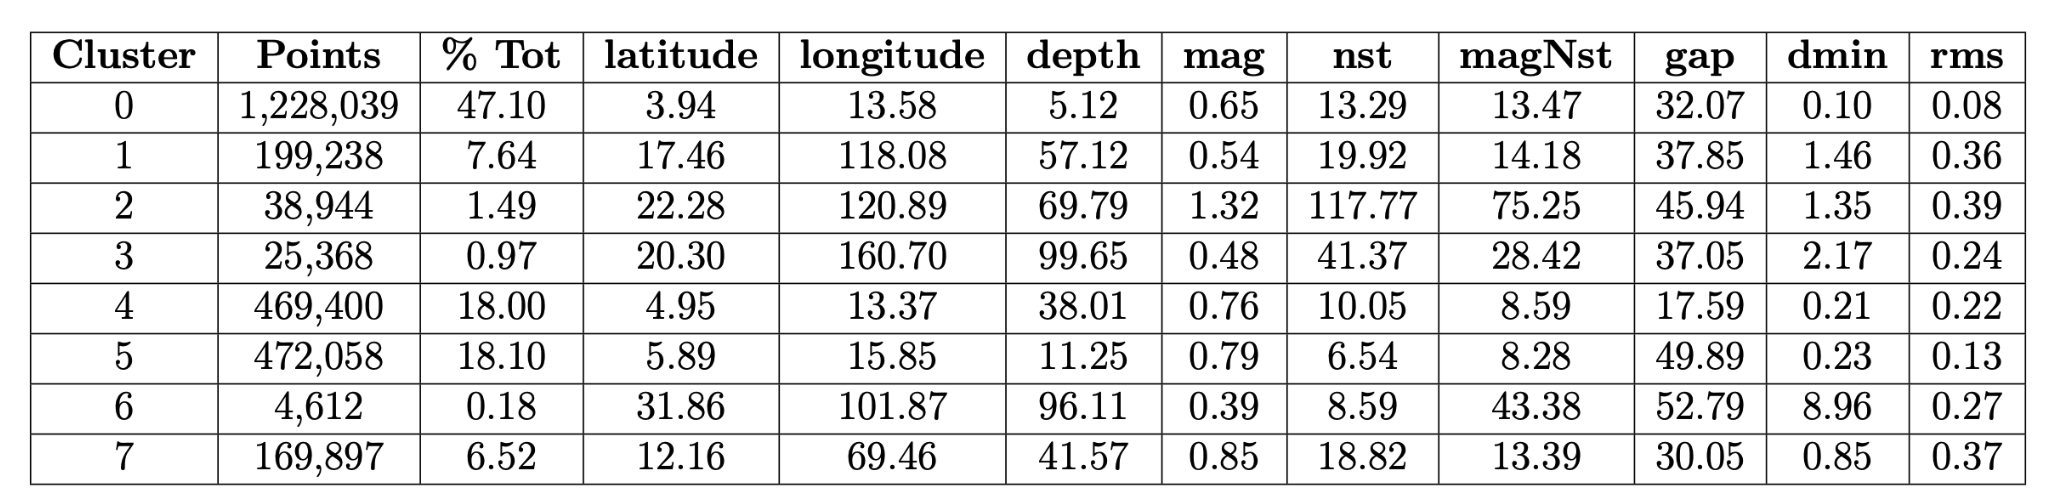

													Max values for each cluster


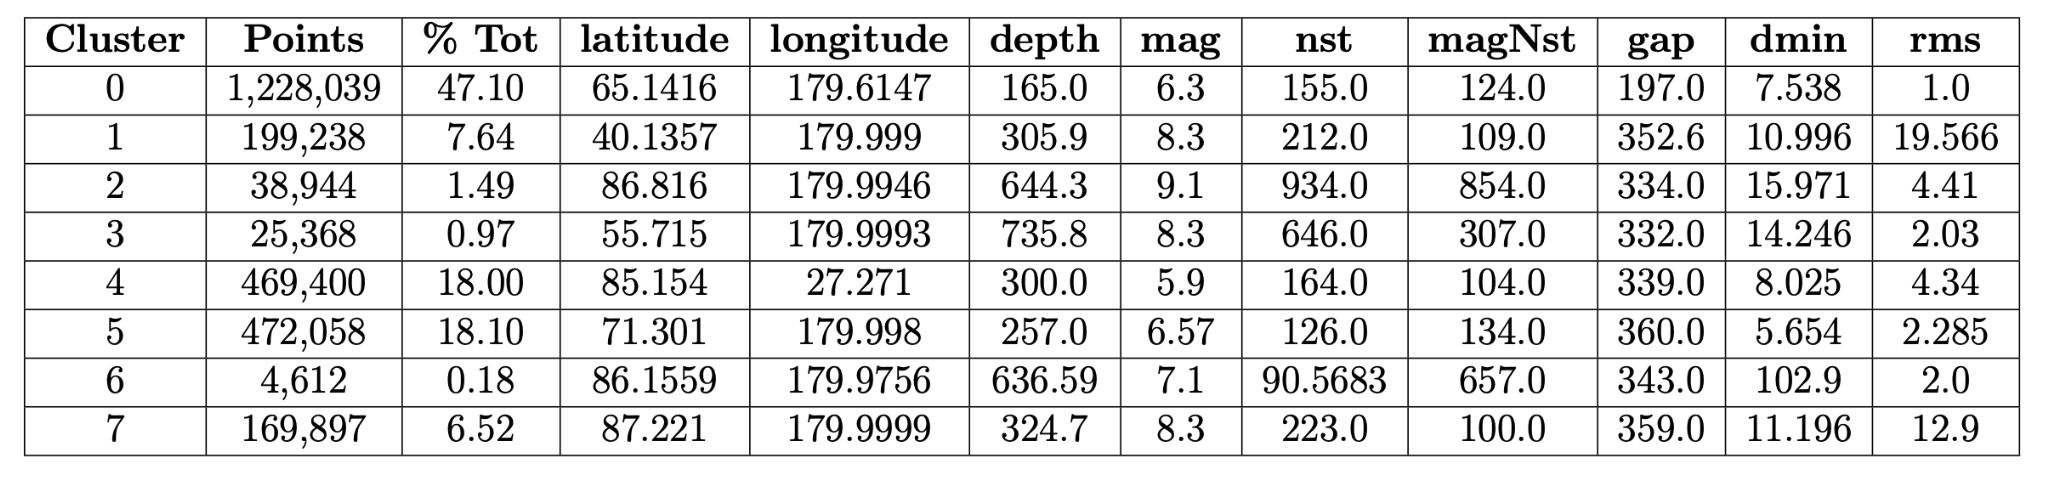

													Min values for each cluster


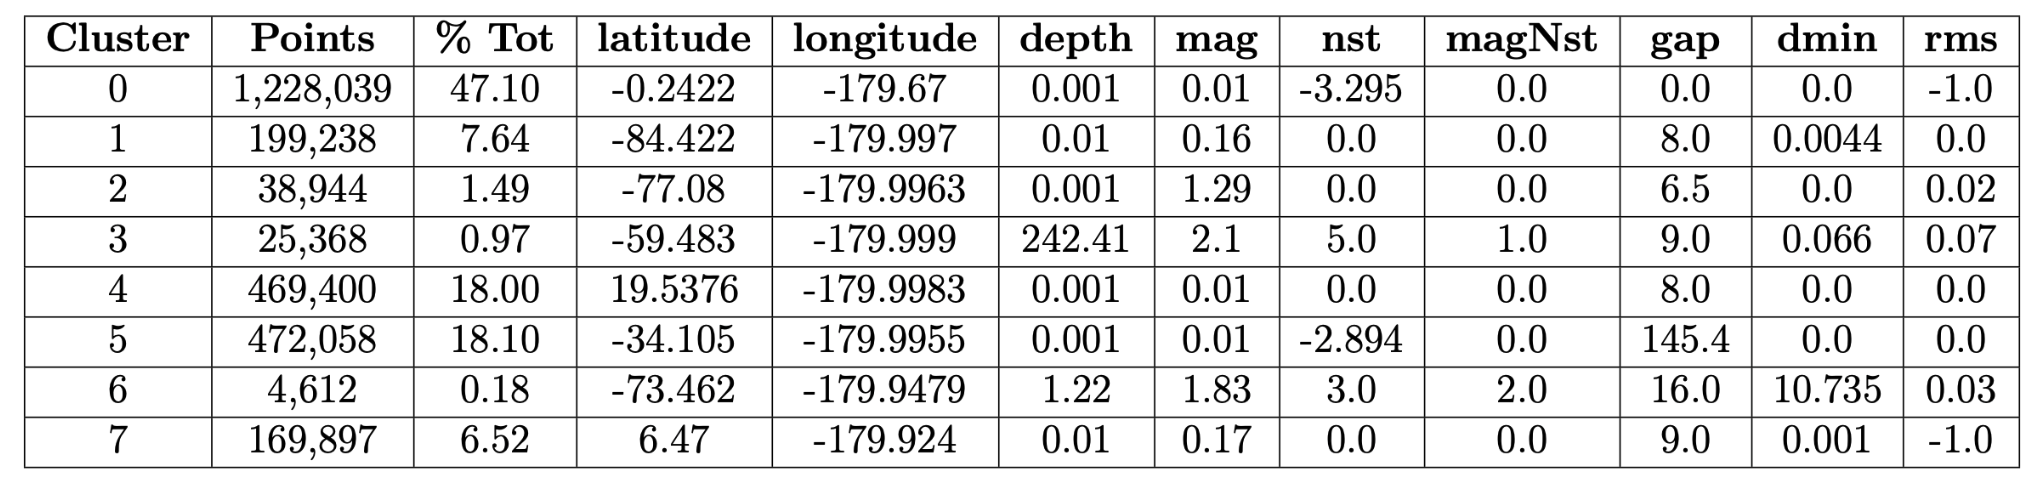

In [29]:
# visualizzo le tabelle che ho creato per il report in latex direttamente qui come foto, 
# in modo da poter vedere le tabelle anche qui direttamente nell'ambiente
from IPython.display import Image, display

# Lista dei percorsi delle immagini
image_paths = [
    './images/clustering_exploration_kmeans/table_mean.png',
    './images/clustering_exploration_kmeans/table_stddev.png',
    './images/clustering_exploration_kmeans/table_max.png',
    './images/clustering_exploration_kmeans/table_min.png'
]

# Stampo tutte e quattro le immagini:
centering = '\t\t\t\t\t\t\t\t\t\t\t\t\t'

for i in range(len(image_paths)):
    if i == 0:
        print(centering + 'Mean for each cluster')
    elif i == 1:
        print(centering + 'Stddev for each cluster')
    elif i == 2:
        print(centering + 'Max values for each cluster')
    else:
        print(centering + 'Min values for each cluster')
    display(Image(filename=image_paths[i]))  
    

## Cluster Analysis

**Cluster 0**
*Majority of Points*: With 47.10% of the points, this cluster is the most numerous, indicating a significant prevalence of seismic activity in its covered area.

*Latitude and Longitude*: Covers a vast geographical area, with earthquakes ranging from near the equator to high northern latitudes. This wide range suggests diverse tectonic settings within the cluster.

*Primary Location*: These coordinates suggest a significant concentration of earthquakes in the western United States, particularly in California and along the West Coast. The very broad range of longitude also implies seismic activity in various other parts of the world.

*Depth and Magnitude*: Generally shallow earthquakes with low magnitude, suggesting less severe seismic activity, possibly associated with minor tectonic movements or localized stress conditions.

*Variation*: Relatively consistent in terms of magnitude and depth, but variable in geographical positioning, indicating a spread of seismic activity over different geological structures.


**Cluster 1**
*Global Distribution*: Covers almost the entire globe in terms of longitude, indicating a widespread seismic presence across various tectonic boundaries.

*Deep Earthquakes*: Significant depths, indicating more intense seismic activity or complex geological regions, possibly including subduction zones or continental rifts.

*High Magnitude*: Higher average magnitude, indicating stronger seismic events, potentially more destructive and noteworthy in terms of seismic hazard.


**Cluster 2**
*Lower Frequency*: Only 1.49% of the points, suggesting it represents a less common type of seismic event.
Wide Variation in Latitude and Longitude: Covers a broad range of positions, indicating a geographically diverse distribution, possibly encompassing different tectonic environments.

*Variable Depth*: Notable variability in depth and magnitude, reflecting a mix of seismic activities, from crustal to deeper mantle processes.


**Cluster 3**
*Extremely Deep*: Very deep earthquakes, potentially indicating seismic activity beneath subduction zones or in deep crustal regions.

*Extreme Latitude and Longitude*: Covers a wide longitudinal range, suggesting a global distribution and possibly including some of the world's most seismically active regions.


**Cluster 4**
*Northern Distribution*: Generally high latitudes, potentially including regions known for consistent seismic activities such as the Pacific Ring of Fire or the circum-Arctic seismic belts.

*Moderate Depth*: Moderate depth and magnitude, indicating a specific type of seismic activity, possibly related to intraplate stresses or moderate tectonic movements.


**Cluster 5**
*Superficial Seismic Activity*: Low average depth, which might indicate earthquakes near the Earth's surface.

*Minimal Variation*: Minimal variation in the statistics, suggesting a more uniform type of seismic event, possibly indicative of consistent geological conditions like those found in stable continental regions.


**Cluster 6**
*Small Cluster*: Very small in terms of the number of events but with high-magnitude earthquakes.

*Wide Variability*: Significant variation in all measures, suggesting a lack of a common pattern or a combination of different types of seismic events, possibly reflecting complex geological interplays.


**Cluster 7**
*Concentrated Geographic Distribution*: Primarily located in the eastern hemisphere with variable depths.

*High Magnitude*: Indicates significant seismic events, potentially in areas with historical seismicity or emerging seismic hotspots.


**General Conclusions**
*Geography*: Some clusters show a more concentrated geographical distribution, while others are globally dispersed, reflecting the varied nature of Earth's tectonic processes.

*Depth and Magnitude*: There is a correlation between the depth of earthquakes and their magnitude, with some clusters representing superficial seismic events and others indicating deep seismic activity.

*Variation in Features*: The clusters differ significantly in terms of features like depth, magnitude, and geographical position, which may reflect differences in the geological and seismic conditions of the regions represented.


In [30]:
df_filtered.show()

+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+
|                time|          latitude|          longitude|             depth| mag|magType|  gap|                dmin| rms|             updated|               place| nst|magNst|            features|      scaledFeatures|kmeans_labels|         pcaFeatures|               pca_1|               pca_2|
+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+
|1971-12-08 07:43:...|47.842833299999995|-119.62116670000002|             6.518| 1.6|     md|301.0|    

In [31]:
# a questo punto possiamo salvare il dataframe con le colonne giuste:
columns_to_write_csv = ["time", "latitude", "longitude", "depth", "mag", "magType", 
                        "gap", "dmin", "rms", "updated", "place", "nst", "magNst", "kmeans_labels"]

# Mantengo la colonna contenente le etichette del clustering, poiché migliorano l'efficacia 
# del modello di classificazione (dopo aver opportunamente effettuato l'hot-one-encoding).
# Utilizzeremo due modelli in modo da poterli confrontare: un DT classifier e un RandomForestClassifier
df_ultimate = df_filtered.select(columns_to_write_csv)

In [32]:
df_ultimate.show()

+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+-------------+
|                time|          latitude|          longitude|             depth| mag|magType|  gap|                dmin| rms|             updated|               place| nst|magNst|kmeans_labels|
+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+-------------+
|1971-12-08 07:43:...|47.842833299999995|-119.62116670000002|             6.518| 1.6|     md|301.0|              0.4872|0.12|2016-07-25 01:51:...|          Washington| 7.0|   7.0|            5|
|1972-11-15 10:11:...|        46.8286667|           -119.473|1.3880000000000001| 0.9|     md|194.0|             0.03549|0.12|2016-07-25 01:57:...|          Washington| 8.0|   8.0|            5|
|1972-11-21 10:27:...|        

In [33]:
# salvo il dataframe spark ulteriormente limato
# (abbiamo rimosso gli outliers multivariati) ed etichettato
df_ultimate.coalesce(1).write.format("csv") \
    .option("header", "true") \
    .mode("overwrite") \
    .option("sep", ",") \
    .save(output_dataset_path)

In [34]:
# Termino la sessione e rilascio le risorse
spark.stop()